# Анализ расчета градиента давления с использованием различных гидравлических корреляций

версия 0.1 от 5.5.20

Что то нарисовать получилось, но надо еще подумать, что получилось то

In [1]:
# подготовимся к импорту API который находится в родительской папке относительно этой тетрадки
import sys
sys.path.insert(0,'..')
# импортируем api
import unifloc_vba_python_api.python_api as python_api 
# готовим объект с доступом к надстройке. При этом надстройка откроется и запустится excel 
UniflocVBA = python_api.API("../UniflocVBA_7.xlam")
print("import excel with unifloc vba done. version " + UniflocVBA.unf_version())

import excel with unifloc vba done. version 7.24


In [2]:
import matplotlib.pyplot as plt
#%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]

## Описание функции  `MF_dpdl_atmm`
Расчет градиента давления может быть выполнен пользовательской функцией `MF_dpdl_atmm`
Функция рассчитывает перепад давления для заданных параметров (расходов жидкости и газа в рабочих условиях и свойтсвах флюидов). Также рассчитывается и перепад давления из за трения.

Расчет может быть проведен для нескольких корреляций, определяемых параметром `hcorr `. Возможные значения ниже. 
````python
    BeggsBrill = 0
    Ansari = 1
    Unified = 2
    Gray = 3
    HagedornBrown = 4
    SakharovMokhov = 5
    gas = 10
    Water = 11

````
Функция возвращает массив значений. Отдельные значения можно вытащить указав номер `param_out`
````python
param_out[0] = dPdLg_out_atmm * c_calibr_grav + dPdLf_out_atmm * c_calibr_fric  # общий градиент давления атм/м
param_out[1] =dPdLg_out_atmm * c_calibr_grav # градиент давления гравитационный атм/м
param_out[2] =dPdLf_out_atmm * c_calibr_fric # градиент давления трения атм/м
param_out[3] =dPdLa_out_atmm # градиент давления инерционный  атм/м
param_out[4] =Vsl_msec # приведенная скорость жидкости м/с
param_out[5] =Vsg_msec # приведенная скорость газа м/с
param_out[6] =Hl_out_fr # истинное содержание жидкости, liquid hold up
param_out[7] =fpat_out_num # номер режима потока
````

Режимы потока кодируются следующими номерами для корреляции Ансари
````python
fpat_out_num = 100 ' " liq" = liquid
fpat_out_num = 101 ' " gas" = gas
fpat_out_num = 105 ' "anul" = annular
fpat_out_num = 104 ' "dbub" = dispersed bubble
fpat_out_num = 103 ' "slug" = slug
fpat_out_num = 102 ' "bubl" = bubbly
fpat_out_num = 199
````

In [3]:
# Подсказку по функции можно посмотреть через команду help
help(UniflocVBA.MF_dpdl_atmm)

Help on method MF_dpdl_atmm in module unifloc_vba_python_api.python_api:

MF_dpdl_atmm(d_m, p_atma, Ql_rc_m3day, Qg_rc_m3day, mu_oil_cP=0.7, mu_gas_cP=0.0122, sigma_oil_gas_Nm=0.025, rho_lrc_kgm3=860.0, rho_grc_kgm3=0.73302, eps_m=0.0001, theta_deg=90, hcorr=1, param_out=0, c_calibr_grav=1, c_calibr_fric=1) method of unifloc_vba_python_api.python_api.API instance
     ========== description ============== 
    расчет градиента давления с использованием многофазных корреляций 
            
     ==========  arguments  ============== 
    
         d_m - диаметр трубы в которой идет поток    
    
         p_atma - давление в точке расчета    
    
         ql_rc_m3day - дебит жидкости в рабочих условиях    
    
         qg_rc_m3day - дебит газа в рабочих условиях    
    
         mu_oil_cp - вязкость нефти в рабочих условиях    
    
         mu_gas_cp - вязкость газа в рабочих условиях    
    
         sigma_oil_gas_nm - поверхностное натяжение  жидкость газ    
    
         rho_lrc

In [4]:
# некоторые параметры которые потребуются для расчета
arr_d_m = 0.062
arr_theta_deg = 90
eps_m = 0.0001
Mul_rc_cP = 1
Mug_rc_cP = 0.01
sigma_l_Nm = 0.02
rho_lrc_kgm3 = 700
rho_grc_kgm3 = 8
p_atma = 10


# дебиты, которые напрямую связаны с приведенными скоростями - будем менять потом
Ql_rc_m3day = 30
Qg_rc_m3day =30

In [5]:
# пример расчета 
UniflocVBA.MF_dpdl_atmm(arr_d_m, p_atma, Ql_rc_m3day, Qg_rc_m3day, Mul_rc_cP, Mug_rc_cP, 
                        sigma_l_Nm, rho_lrc_kgm3, rho_grc_kgm3,eps_m,theta_deg=90, hcorr = 2)

(0.04843776026202962,
 0.048838535668101445,
 -0.0004007754060718311,
 -0.0,
 0.11500964207704324,
 0.11500964207704324,
 0.7174000557662611,
 203)

## Зададим процедуру построения графиков
Чтобы потом для разных корреляций быстро построить картинки

In [6]:
ql_list = range(1,1501,50)
qg_list = range(1,3501,100)
qln = len(ql_list) # для удобства индексации найдем количество точек
qgn = len(qg_list)
# init empty 2d list for results
dpdl_list =  [[0 for x in range(qgn)] for y in range(qln)] 
def plot_maps_graphs(corr, corr_name):
    # Зададим диапазон дебитов жидкости и газа для построения карты
    # Для большого количества точек расчет может занимать заметное время (но карта при этом будет лучше)


    print("Задано точек " + str(qln) +" для q_liq, "+ str(qgn) +" для q_gas, всего " + str(qln*qgn) + " расчетов")
    print("Если расчетов много то будет считать долго ...")



    for ql in range(qln):
        for qg in range(qgn):
            dpdl = UniflocVBA.MF_dpdl_atmm(arr_d_m, p_atma, ql_list[ql], qg_list[qg], Mul_rc_cP, Mug_rc_cP, 
                            sigma_l_Nm, rho_lrc_kgm3, rho_grc_kgm3,eps_m,theta_deg=90, hcorr = corr)
            dpdl_list[ql][qg] = dpdl 
        print(str(ql)+" ", end="")
    print(".")
    print("расчет завершен")
    # ========================================================================
    print("строим карту режимов потока для корреляции " + corr_name)
    # extract flow regime num from results array
    ar = [[a[7] for a in qgl] for qgl in dpdl_list]
    # plot it
    fig = plt.figure()
    plt.pcolormesh(qg_list,ql_list,ar)
    plt.xlabel('q gas')
    plt.ylabel('q liq')
    plt.colorbar(ticks=range(220))
    fig.suptitle(corr_name + " flow regimes map for specific fluid properties", fontsize = 18)
    plt.show()
    # ========================================================================
    print("строим карту значений градиента для корреляции " + corr_name)
    ar = [[a[0] for a in qgl] for qgl in dpdl_list]

    fig = plt.figure()
    plt.pcolormesh(qg_list,ql_list,ar)
    plt.xlabel('q gas')
    plt.ylabel('q liq')
    plt.colorbar()
    fig.suptitle(corr_name + " dp/dl for specific fluid properties", fontsize = 18)
    plt.show()
    
    # ========================================================================
    print("строим графики градиента для корреляции " + corr_name)
    fig = plt.figure()
    for i in range(qln):
        plt.plot(qg_list, ar[i] )
    plt.xlabel('q gas')
    plt.ylabel('dp/dl atm/m')
    fig.suptitle(corr_name + "dp/dl for specific fluid properties", fontsize = 18)
    plt.show()
    
    fig = plt.figure()
    for j in range(qgn):
        plt.plot(ql_list, [dpdl_list[i][j][0] for i in range(qln)] )
    plt.xlabel('q liq')
    plt.ylabel('dp/dl atm/m')
    fig.suptitle(corr_name + " dp/dl for specific fluid properties", fontsize = 18)
    plt.show()
    
    print("строим графики соствляющих градиента для корреляции " + corr_name)
    fig = plt.figure()
    for j in range(qgn):
        plt.plot(ql_list, [dpdl_list[i][j][1] for i in range(qln)] )
    plt.xlabel('q liq')
    plt.ylabel('dp/dl atm/m')
    fig.suptitle(corr_name + " gravity dp/dl for specific fluid properties", fontsize = 18)
    plt.show()

    fig = plt.figure()
    for j in range(qgn):
        plt.plot(ql_list, [dpdl_list[i][j][2] for i in range(qln)] )
    plt.xlabel('q liq')
    plt.ylabel('dp/dl atm/m')
    fig.suptitle(corr_name + " friction dp/dl for specific fluid properties", fontsize = 18)
    plt.show()

    fig = plt.figure()
    for j in range(qgn):
        plt.plot(ql_list, [dpdl_list[i][j][3] for i in range(qln)] )
    plt.xlabel('q liq')
    plt.ylabel('dp/dl atm/m')
    fig.suptitle(corr_name + " aceleration dp/dl for specific fluid properties", fontsize = 18)
    plt.show()

## Построение карты режимов потока для корреляции Ансари

Режимы потока кодируются следующими номерами для корреляции Ансари
````python
fpat_out_num = 100 ' " liq" = liquid
fpat_out_num = 101 ' " gas" = gas
fpat_out_num = 105 ' "anul" = annular
fpat_out_num = 104 ' "dbub" = dispersed bubble
fpat_out_num = 103 ' "slug" = slug
fpat_out_num = 102 ' "bubl" = bubbly
fpat_out_num = 199
````

Задано точек 30 для q_liq, 35 для q_gas, всего 1050 расчетов
Если расчетов много то будет считать долго ...
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 .
расчет завершен
строим карту режимов потока для корреляции Ansari


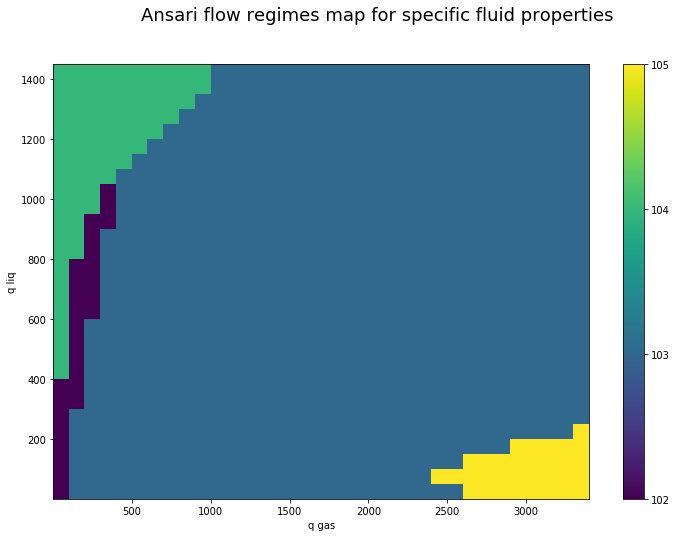

строим карту значений градиента для корреляции Ansari


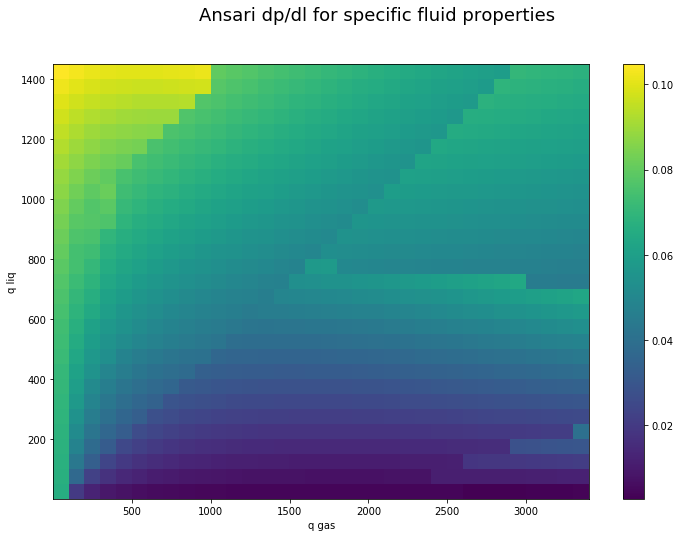

строим графики градиента для корреляции Ansari


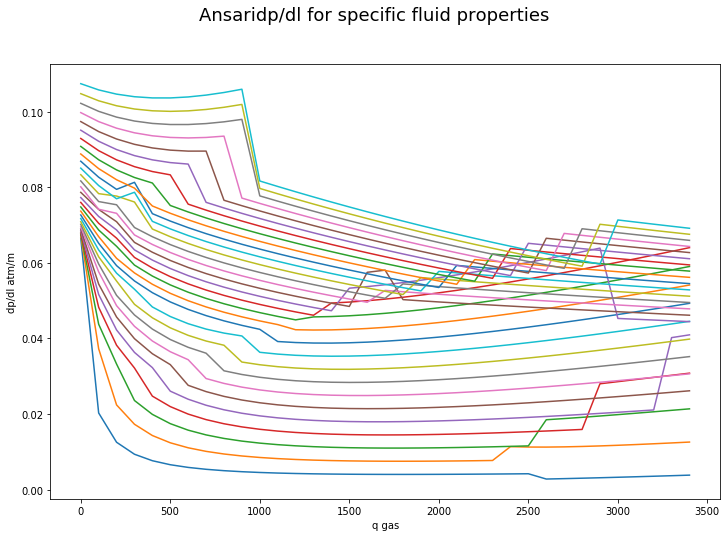

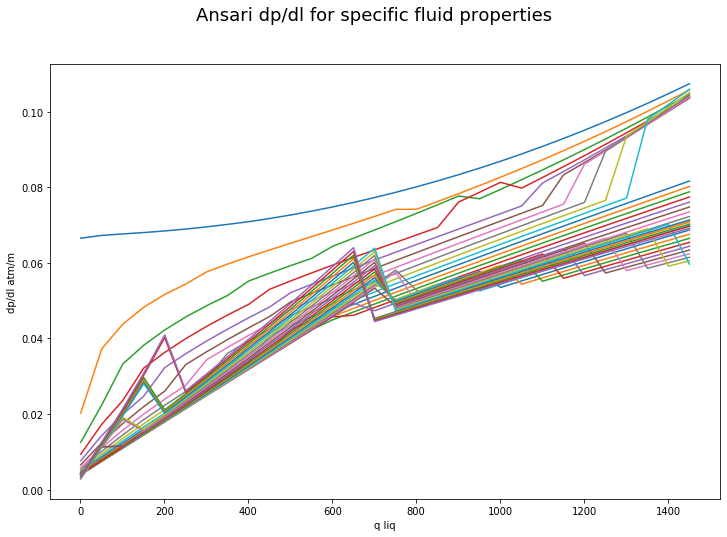

строим графики соствляющих градиента для корреляции Ansari


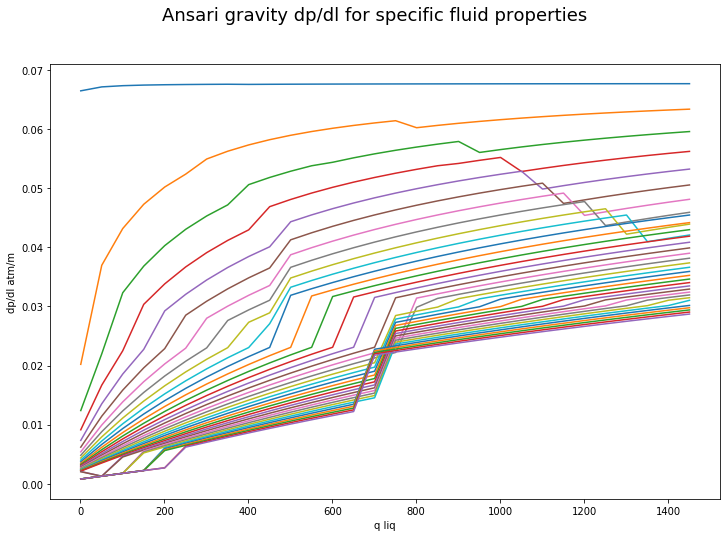

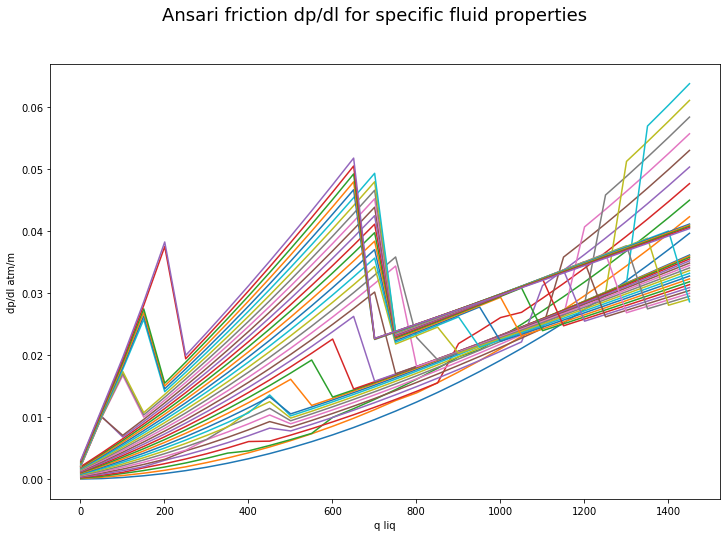

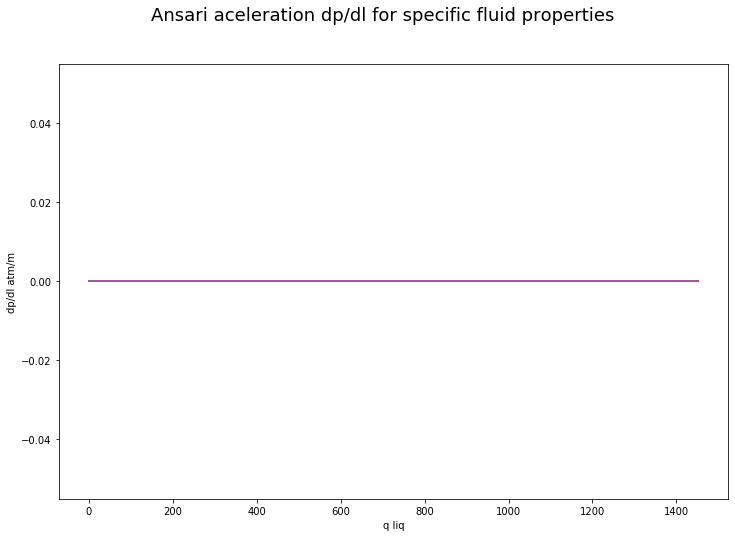

In [7]:
plot_maps_graphs(1,"Ansari")

## Построение карты режимов потока для корреляции Беггса Брилла



Задано точек 30 для q_liq, 35 для q_gas, всего 1050 расчетов
Если расчетов много то будет считать долго ...
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 .
расчет завершен
строим карту режимов потока для корреляции Beggs Brill


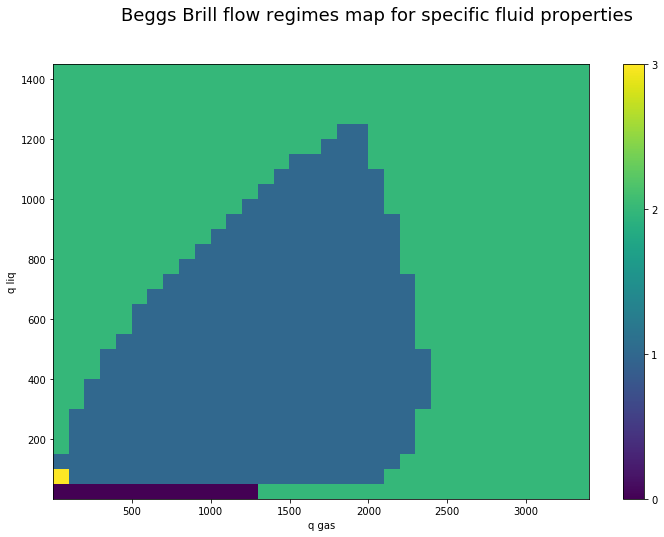

строим карту значений градиента для корреляции Beggs Brill


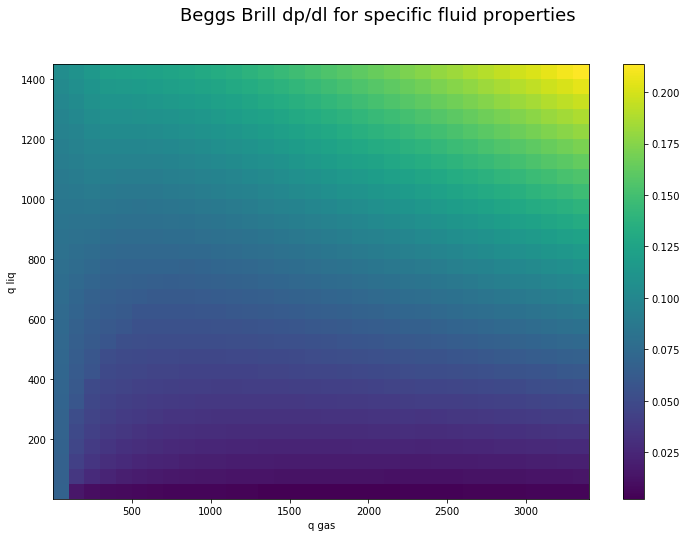

строим графики градиента для корреляции Beggs Brill


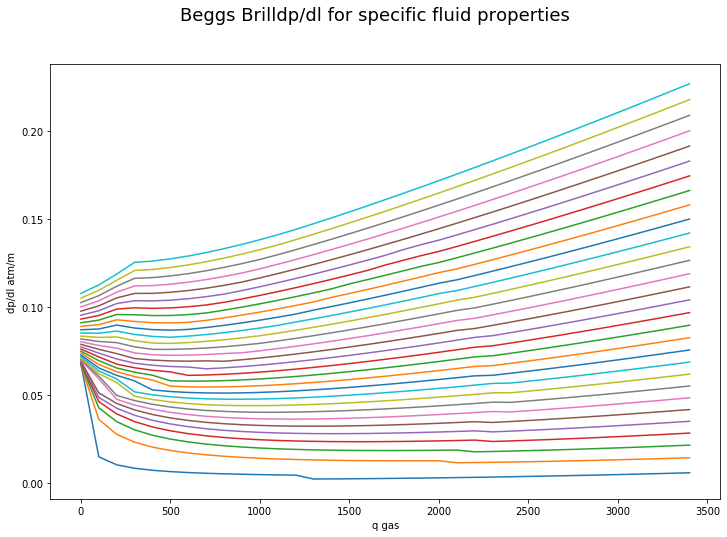

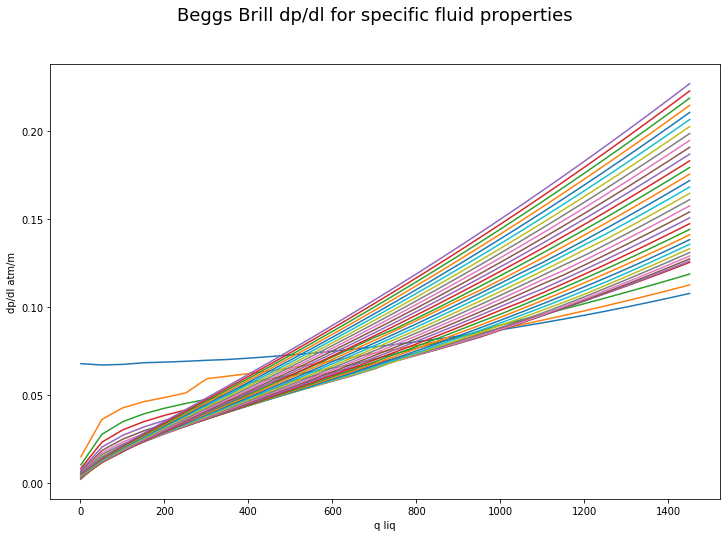

строим графики соствляющих градиента для корреляции Beggs Brill


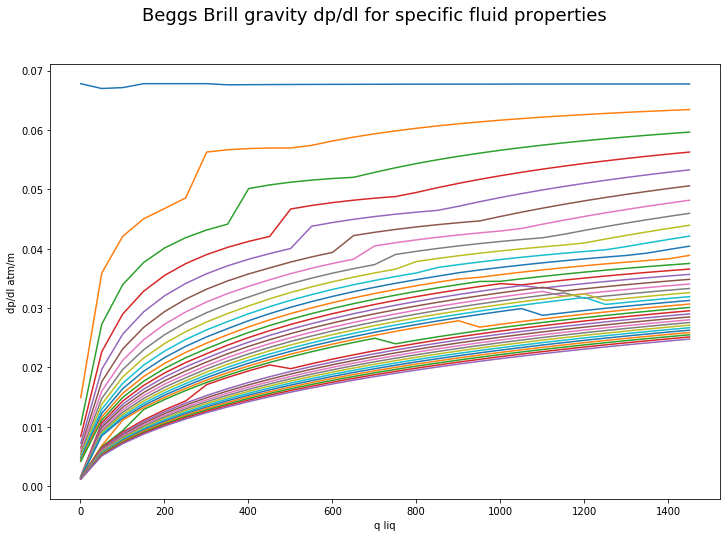

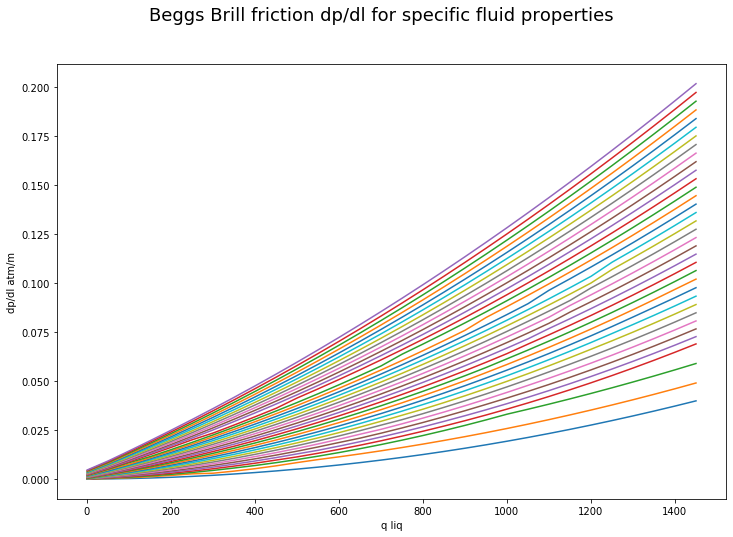

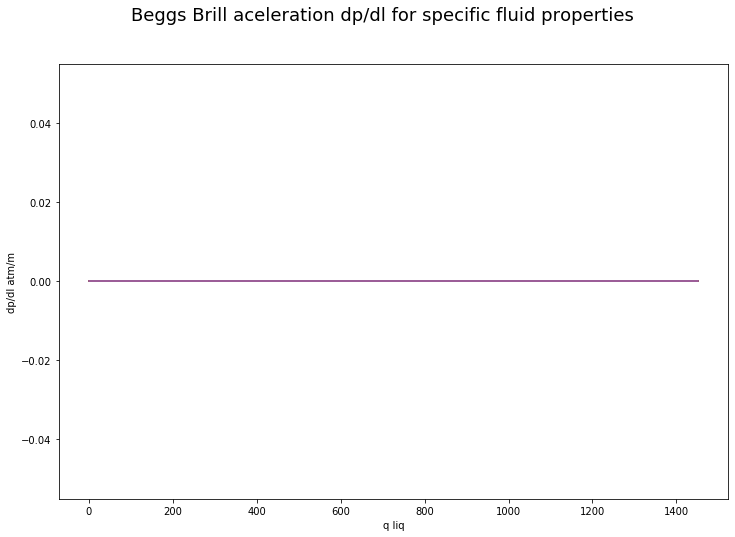

In [8]:
plot_maps_graphs(0,"Beggs Brill")

## Построение карты режимов потока для корреляции Unified



Задано точек 30 для q_liq, 35 для q_gas, всего 1050 расчетов
Если расчетов много то будет считать долго ...
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 .
расчет завершен
строим карту режимов потока для корреляции Unified


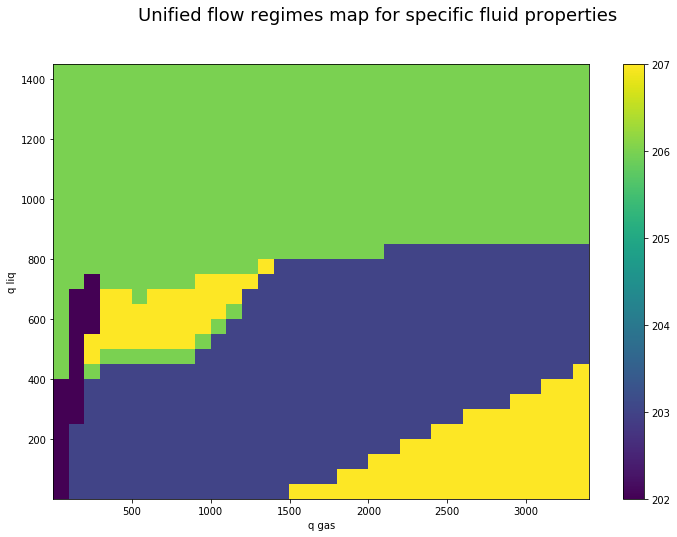

строим карту значений градиента для корреляции Unified


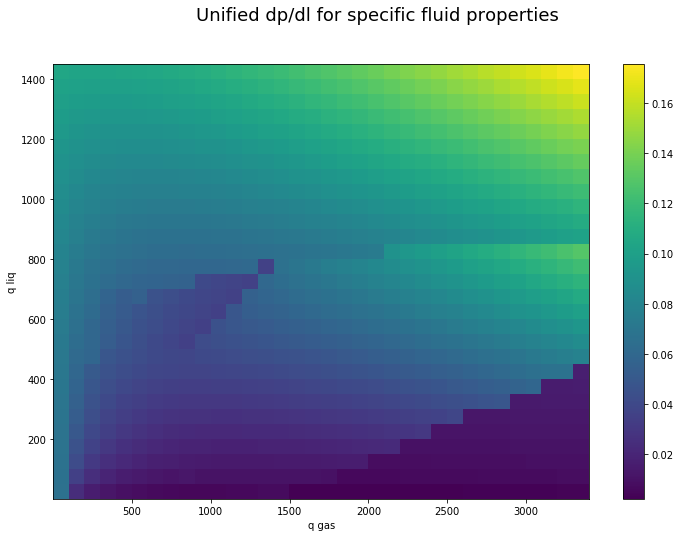

строим графики градиента для корреляции Unified


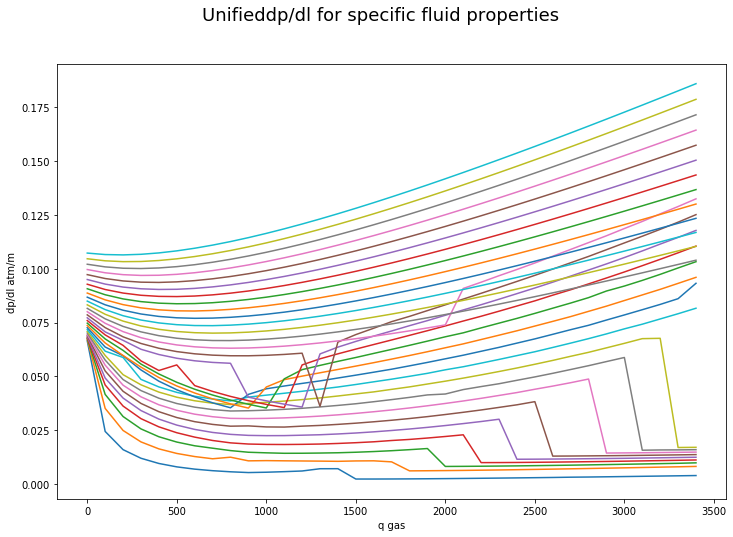

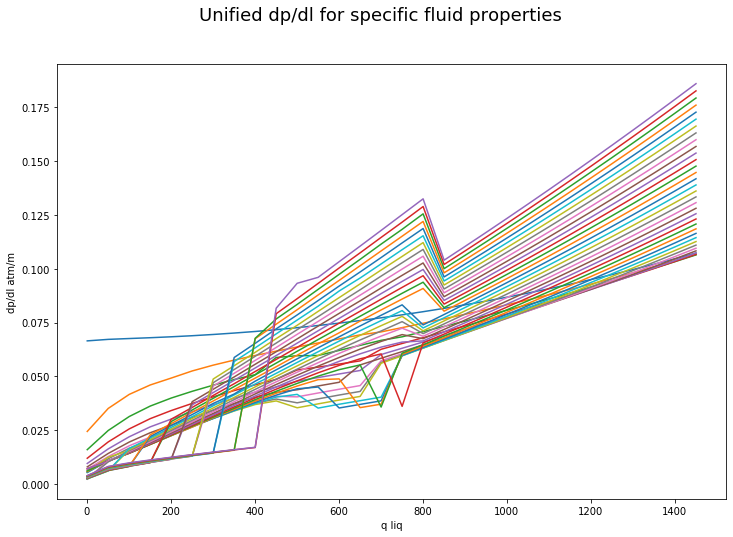

строим графики соствляющих градиента для корреляции Unified


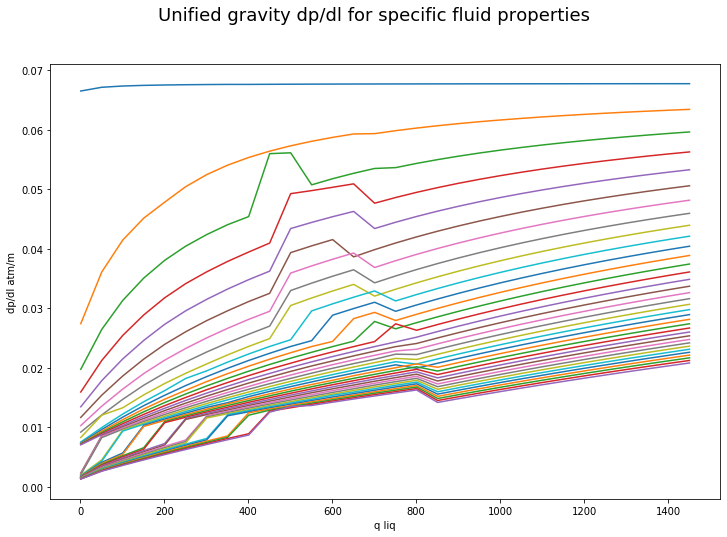

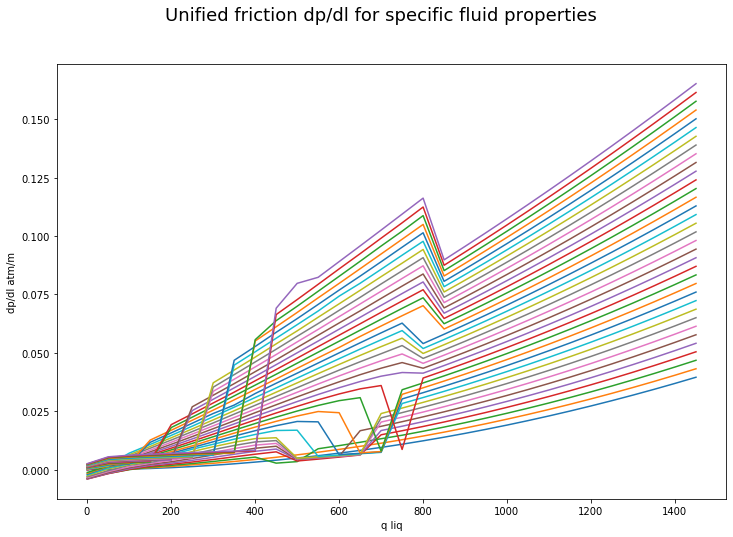

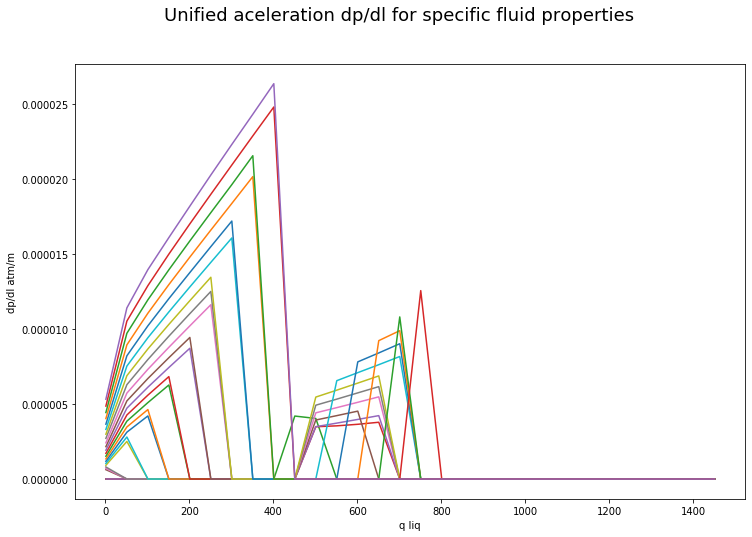

In [9]:
plot_maps_graphs(2,"Unified")

## Построение карты режимов потока для корреляции Gray



Задано точек 30 для q_liq, 35 для q_gas, всего 1050 расчетов
Если расчетов много то будет считать долго ...
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 .
расчет завершен
строим карту режимов потока для корреляции Gray


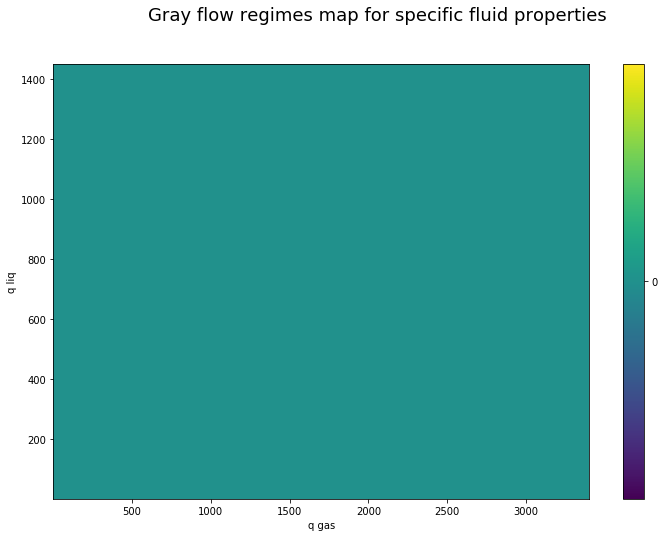

строим карту значений градиента для корреляции Gray


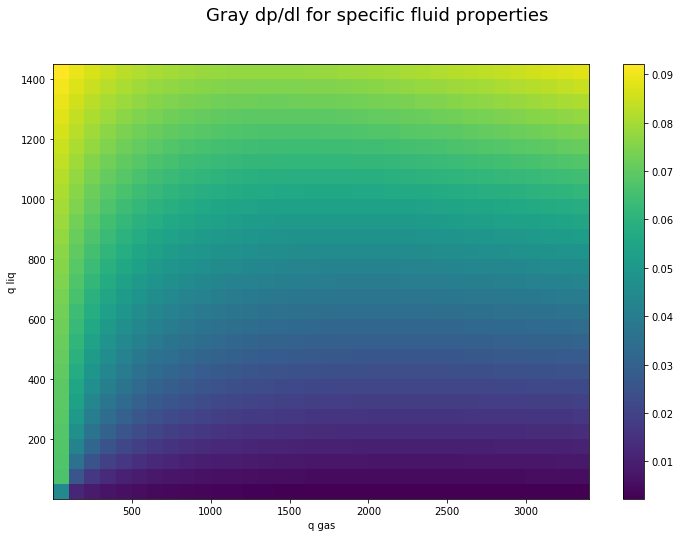

строим графики градиента для корреляции Gray


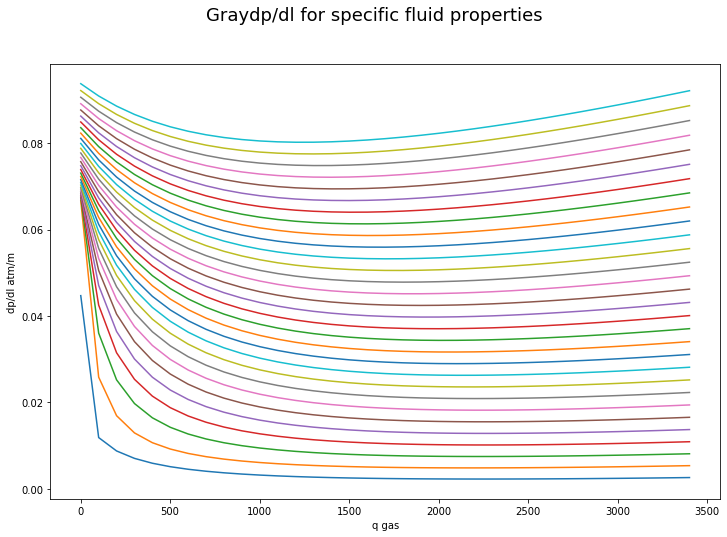

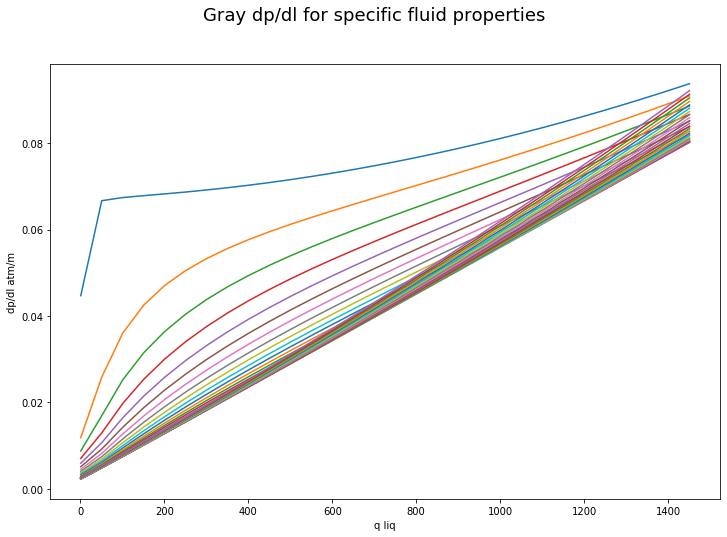

строим графики соствляющих градиента для корреляции Gray


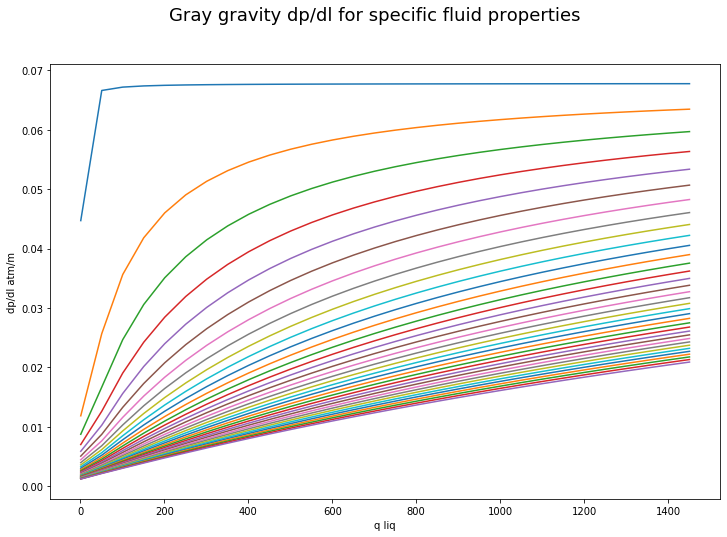

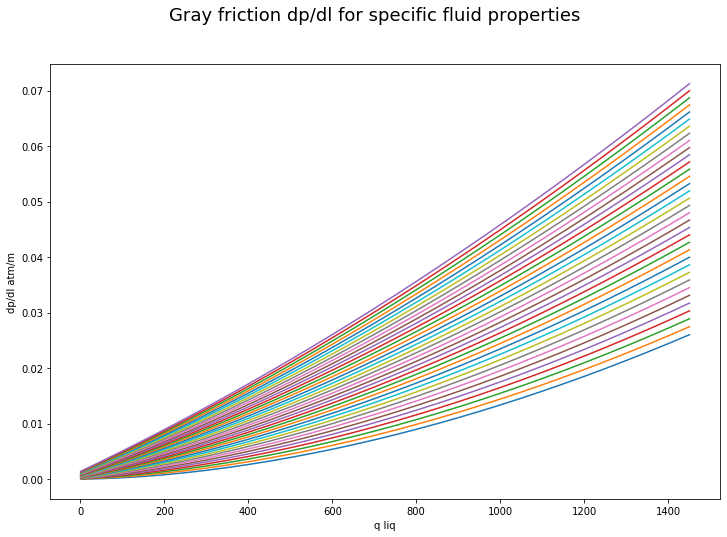

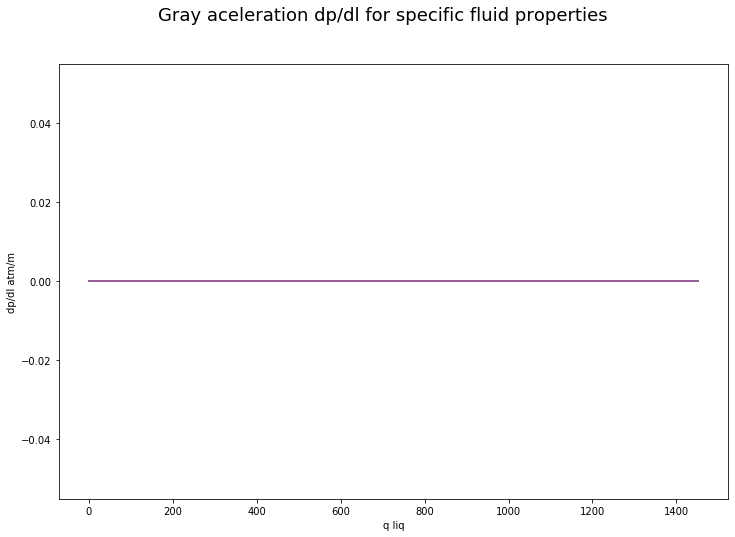

In [10]:
plot_maps_graphs(3,"Gray")

## Построение карты режимов потока для корреляции Hagedorn Brawn


Задано точек 30 для q_liq, 35 для q_gas, всего 1050 расчетов
Если расчетов много то будет считать долго ...
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 .
расчет завершен
строим карту режимов потока для корреляции Hagedorn Brawn


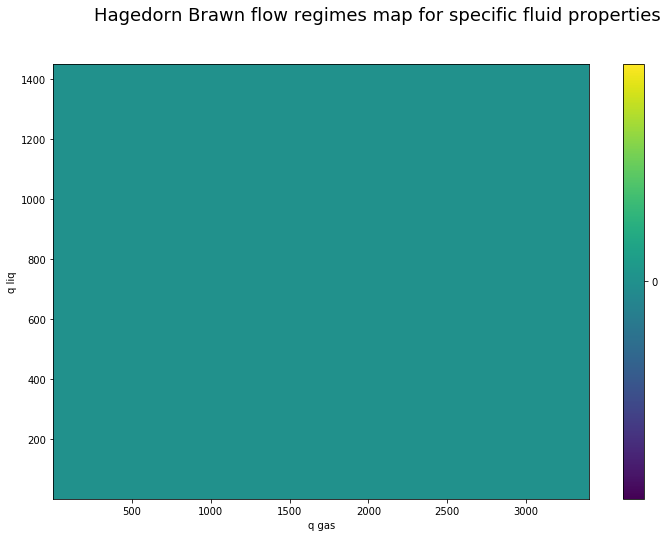

строим карту значений градиента для корреляции Hagedorn Brawn


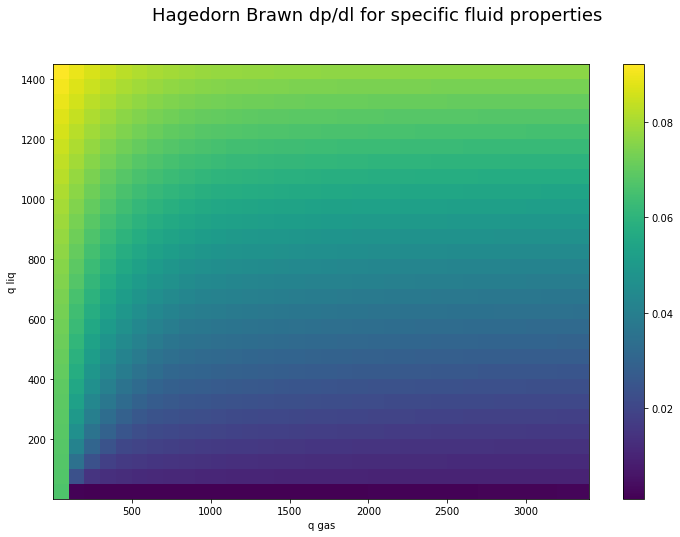

строим графики градиента для корреляции Hagedorn Brawn


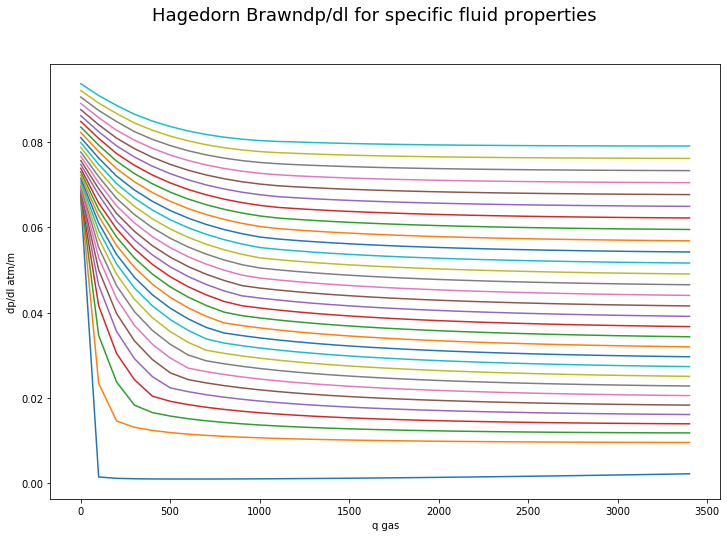

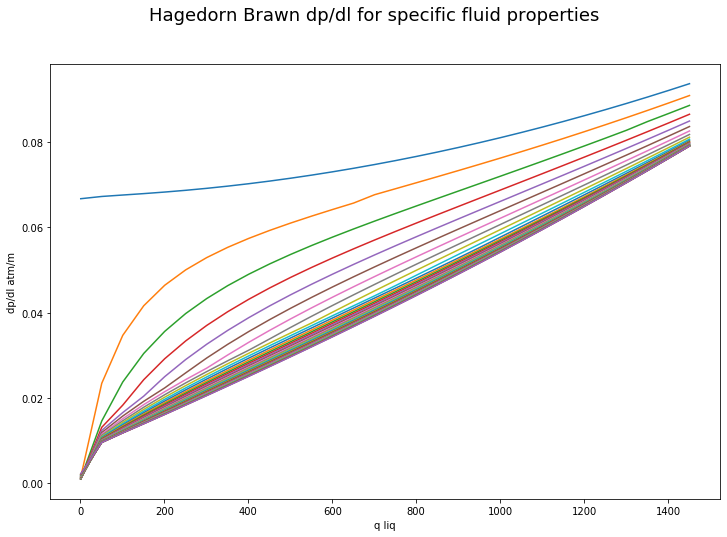

строим графики соствляющих градиента для корреляции Hagedorn Brawn


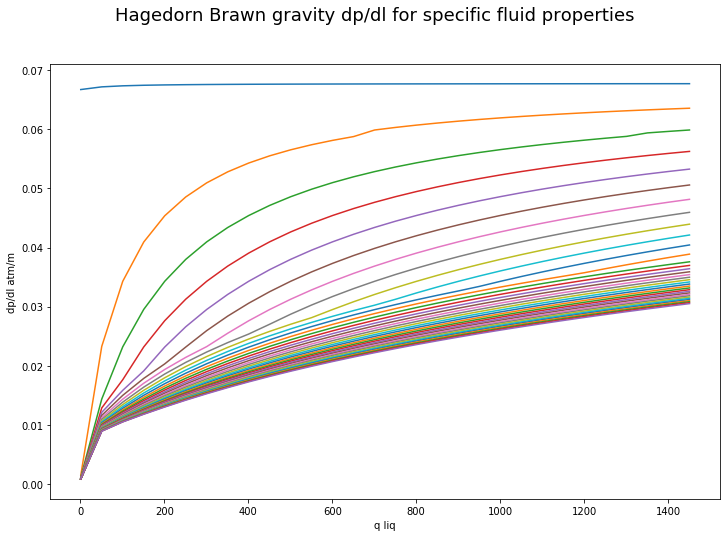

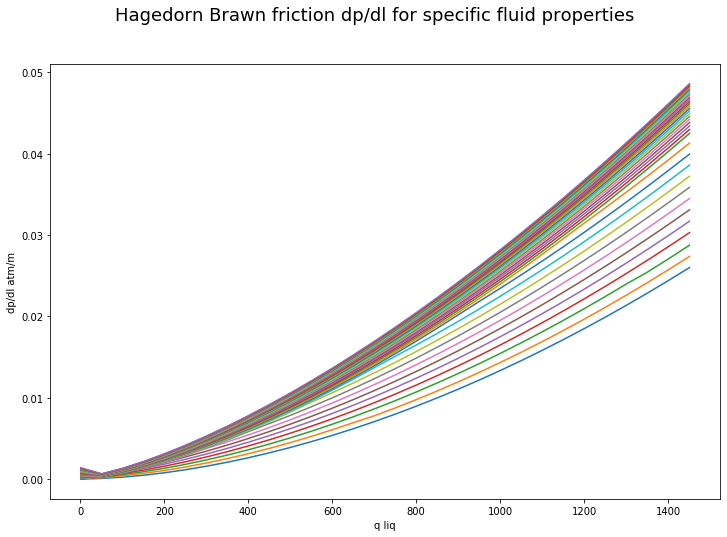

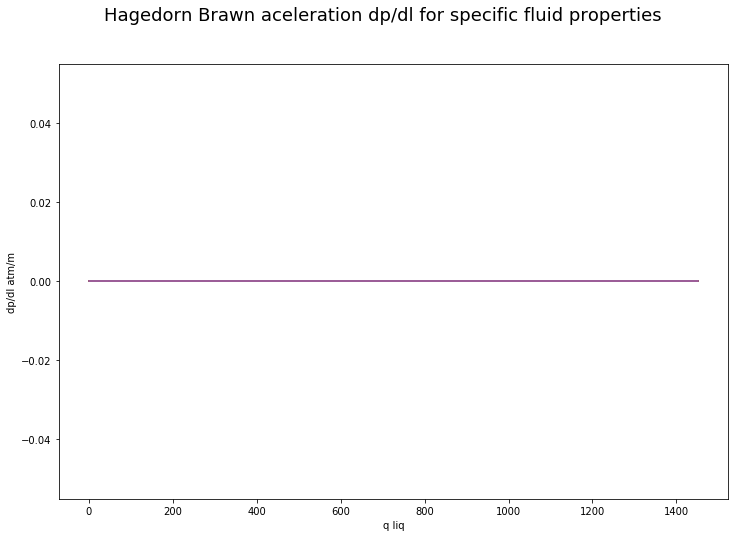

In [11]:
plot_maps_graphs(4,"Hagedorn Brawn")